In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 32
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [4]:
## Resample training data
#resample_data(train_dir)
#resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'inceptionv3.2.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
63/63 [==============================] - 15s 220ms/step
Epoch 1 - Validation Loss: 4.5069, Validation Accuracy: 0.4913, Validation Precision: 0.4422

Epoch 1: val_loss improved from inf to 4.50686, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 150s - loss: 5.1461 - acc: 0.1866 - val_loss: 4.5069 - val_acc: 0.4913 - lr: 1.0000e-04 - 150s/epoch - 1s/step
Epoch 2/1000
63/63 [==============================] - 15s 234ms/step
Epoch 2 - Validation Loss: 3.9436, Validation Accuracy: 0.3212, Validation Precision: 0.4490

Epoch 2: val_loss improved from 4.50686 to 3.94363, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 142s - loss: 4.2262 - acc: 0.2220 - val_loss: 3.9436 - val_acc: 0.3212 - lr: 1.0000e-04 - 142s/epoch - 1s/step
Epoch 3/1000
63/63 [==============================] - 15s 237ms/step
Epoch 3 - Validation Loss: 3.6135, Validation Accuracy: 0.1860, Validation Precision: 0.5181

Epoch 3: val_loss improved from 3.94363 to 3.61354, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 159s - loss: 3.5851 - acc: 0.2883 - val_loss: 3.6135 - val_acc: 0.1860 - lr: 1.0000e-04 - 159s/epoch - 1s/step
Epoch 4/1000
63/63 [==============================] - 15s 243ms/step
Epoch 4 - Validation Loss: 2.9722, Validation Accuracy: 0.5172, Validation Precision: 0.4597

Epoch 4: val_loss improved from 3.61354 to 2.97224, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 158s - loss: 3.1424 - acc: 0.3249 - val_loss: 2.9722 - val_acc: 0.5172 - lr: 1.0000e-04 - 158s/epoch - 1s/step
Epoch 5/1000
63/63 [==============================] - 15s 231ms/step
Epoch 5 - Validation Loss: 2.7478, Validation Accuracy: 0.4728, Validation Precision: 0.4572

Epoch 5: val_loss improved from 2.97224 to 2.74783, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 155s - loss: 2.8523 - acc: 0.3194 - val_loss: 2.7478 - val_acc: 0.4728 - lr: 1.0000e-04 - 155s/epoch - 1s/step
Epoch 6/1000
63/63 [==============================] - 15s 230ms/step
Epoch 6 - Validation Loss: 2.5799, Validation Accuracy: 0.4683, Validation Precision: 0.4674

Epoch 6: val_loss improved from 2.74783 to 2.57988, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 156s - loss: 2.6443 - acc: 0.3360 - val_loss: 2.5799 - val_acc: 0.4683 - lr: 1.0000e-04 - 156s/epoch - 1s/step
Epoch 7/1000
63/63 [==============================] - 15s 230ms/step
Epoch 7 - Validation Loss: 2.4333, Validation Accuracy: 0.5501, Validation Precision: 0.4732

Epoch 7: val_loss improved from 2.57988 to 2.43325, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 142s - loss: 2.4907 - acc: 0.3483 - val_loss: 2.4333 - val_acc: 0.5501 - lr: 1.0000e-04 - 142s/epoch - 1s/step
Epoch 8/1000
63/63 [==============================] - 15s 234ms/step
Epoch 8 - Validation Loss: 2.3058, Validation Accuracy: 0.6314, Validation Precision: 0.4730

Epoch 8: val_loss improved from 2.43325 to 2.30585, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 151s - loss: 2.3784 - acc: 0.3403 - val_loss: 2.3058 - val_acc: 0.6314 - lr: 1.0000e-04 - 151s/epoch - 1s/step
Epoch 9/1000
63/63 [==============================] - 14s 226ms/step
Epoch 9 - Validation Loss: 2.2236, Validation Accuracy: 0.6025, Validation Precision: 0.4799

Epoch 9: val_loss improved from 2.30585 to 2.22356, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 152s - loss: 2.2695 - acc: 0.3706 - val_loss: 2.2236 - val_acc: 0.6025 - lr: 1.0000e-04 - 152s/epoch - 1s/step
Epoch 10/1000
63/63 [==============================] - 16s 245ms/step
Epoch 10 - Validation Loss: 2.2329, Validation Accuracy: 0.5372, Validation Precision: 0.4844

Epoch 10: val_loss did not improve from 2.22356
110/110 - 146s - loss: 2.2075 - acc: 0.3574 - val_loss: 2.2329 - val_acc: 0.5372 - lr: 1.0000e-04 - 146s/epoch - 1s/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 232ms/step
Epoch 11 - Validation Loss: 2.1016, Validation Accuracy: 0.6628, Validation Precision: 0.4780

Epoch 11: val_loss improved from 2.22356 to 2.10158, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 153s - loss: 2.1340 - acc: 0.3851 - val_loss: 2.1016 - val_acc: 0.6628 - lr: 1.0000e-04 - 153s/epoch - 1s/step
Epoch 12/1000
63/63 [==============================] - 16s 259ms/step
Epoch 12 - Validation Loss: 2.0804, Validation Accuracy: 0.6319, Validation Precision: 0.4636

Epoch 12: val_loss improved from 2.10158 to 2.08038, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 156s - loss: 2.0970 - acc: 0.3831 - val_loss: 2.0804 - val_acc: 0.6319 - lr: 1.0000e-04 - 156s/epoch - 1s/step
Epoch 13/1000
63/63 [==============================] - 15s 240ms/step
Epoch 13 - Validation Loss: 2.0398, Validation Accuracy: 0.6010, Validation Precision: 0.4638

Epoch 13: val_loss improved from 2.08038 to 2.03977, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 157s - loss: 2.0371 - acc: 0.3983 - val_loss: 2.0398 - val_acc: 0.6010 - lr: 1.0000e-04 - 157s/epoch - 1s/step
Epoch 14/1000
63/63 [==============================] - 15s 230ms/step
Epoch 14 - Validation Loss: 2.0932, Validation Accuracy: 0.4888, Validation Precision: 0.4775

Epoch 14: val_loss did not improve from 2.03977
110/110 - 150s - loss: 1.9932 - acc: 0.3966 - val_loss: 2.0932 - val_acc: 0.4888 - lr: 1.0000e-04 - 150s/epoch - 1s/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 233ms/step
Epoch 15 - Validation Loss: 2.0842, Validation Accuracy: 0.4888, Validation Precision: 0.4668

Epoch 15: val_loss did not improve from 2.03977
110/110 - 152s - loss: 1.9515 - acc: 0.4009 - val_loss: 2.0842 - val_acc: 0.4888 - lr: 1.0000e-04 - 152s/epoch - 1s/step
Epoch 16/1000
63/63 [==============================] - 14s 229ms/step
Epoch 16 - Validation Loss: 1.9483, Validation Accuracy: 0.6075, Validation Precision: 0.4850

Epoch 16: val_loss improved from 2.03977 to 1.94831, saving model to inceptionv3.2.h5
110/110 - 153s - loss: 1.9176 - acc: 0.4189 - val_loss: 1.9483 - val_acc: 0.6075 - lr: 1.0000e-04 - 153s/epoch - 1s/step
Epoch 17/1000
63/63 [==============================] - 15s 231ms/step
Epoch 17 - Validation Loss: 1.8967, Validation Accuracy: 0.6559, Validation Precision: 0.4687

Epoch 17: val_loss improved from 1.94831 to 1.89672, saving model to inceptionv3.2.h5
110/110 - 149s - loss: 1.8891 - acc: 0.4037 - val_loss: 1

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 231ms/step
Epoch 23 - Validation Loss: 1.7840, Validation Accuracy: 0.6374, Validation Precision: 0.4713

Epoch 23: val_loss did not improve from 1.76130
110/110 - 152s - loss: 1.7557 - acc: 0.4366 - val_loss: 1.7840 - val_acc: 0.6374 - lr: 1.0000e-04 - 152s/epoch - 1s/step
Epoch 24/1000
63/63 [==============================] - 15s 233ms/step
Epoch 24 - Validation Loss: 1.7550, Validation Accuracy: 0.6524, Validation Precision: 0.4693

Epoch 24: val_loss improved from 1.76130 to 1.75496, saving model to inceptionv3.2.h5
110/110 - 151s - loss: 1.7186 - acc: 0.4597 - val_loss: 1.7550 - val_acc: 0.6524 - lr: 1.0000e-04 - 151s/epoch - 1s/step
Epoch 25/1000
63/63 [==============================] - 15s 233ms/step
Epoch 25 - Validation Loss: 1.7257, Validation Accuracy: 0.6623, Validation Precision: 0.4828

Epoch 25: val_loss improved from 1.75496 to 1.72568, saving model to inceptionv3.2.h5
110/110 - 153s - loss: 1.6967 - acc: 0.4646 - val_loss: 1

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 233ms/step
Epoch 29 - Validation Loss: 1.6947, Validation Accuracy: 0.6469, Validation Precision: 0.4696

Epoch 29: val_loss improved from 1.69818 to 1.69475, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 161s - loss: 1.6411 - acc: 0.4720 - val_loss: 1.6947 - val_acc: 0.6469 - lr: 1.0000e-04 - 161s/epoch - 1s/step
Epoch 30/1000
63/63 [==============================] - 15s 231ms/step
Epoch 30 - Validation Loss: 1.7087, Validation Accuracy: 0.6165, Validation Precision: 0.4816

Epoch 30: val_loss did not improve from 1.69475
110/110 - 153s - loss: 1.6278 - acc: 0.4654 - val_loss: 1.7087 - val_acc: 0.6165 - lr: 1.0000e-04 - 153s/epoch - 1s/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 233ms/step
Epoch 31 - Validation Loss: 1.6743, Validation Accuracy: 0.6329, Validation Precision: 0.4641

Epoch 31: val_loss improved from 1.69475 to 1.67431, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 149s - loss: 1.6034 - acc: 0.4771 - val_loss: 1.6743 - val_acc: 0.6329 - lr: 1.0000e-04 - 149s/epoch - 1s/step
Epoch 32/1000
63/63 [==============================] - 14s 225ms/step
Epoch 32 - Validation Loss: 1.6875, Validation Accuracy: 0.6219, Validation Precision: 0.4531

Epoch 32: val_loss did not improve from 1.67431
110/110 - 152s - loss: 1.5841 - acc: 0.4729 - val_loss: 1.6875 - val_acc: 0.6219 - lr: 1.0000e-04 - 152s/epoch - 1s/step
Epoch 33/1000
63/63 [==============================] - 16s 256ms/step
Epoch 33 - Validation Loss: 1.6817, Validation Accuracy: 0.6075, Validation Precision: 0.4667

Epoch 33: val_loss did not improve from 1.67431
110/110 - 145s - loss: 1.5784 - acc: 0.4826 - val_loss: 1.6817 - val_acc: 0.6075 - lr: 1.0000e-04 - 145s/epoch - 1s/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 16s 246ms/step
Epoch 34 - Validation Loss: 1.6334, Validation Accuracy: 0.6454, Validation Precision: 0.4684

Epoch 34: val_loss improved from 1.67431 to 1.63338, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 159s - loss: 1.5473 - acc: 0.4911 - val_loss: 1.6334 - val_acc: 0.6454 - lr: 1.0000e-04 - 159s/epoch - 1s/step
Epoch 35/1000
63/63 [==============================] - 15s 232ms/step
Epoch 35 - Validation Loss: 1.6874, Validation Accuracy: 0.6035, Validation Precision: 0.4782

Epoch 35: val_loss did not improve from 1.63338
110/110 - 153s - loss: 1.5494 - acc: 0.4771 - val_loss: 1.6874 - val_acc: 0.6035 - lr: 1.0000e-04 - 153s/epoch - 1s/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 237ms/step
Epoch 36 - Validation Loss: 1.6802, Validation Accuracy: 0.5845, Validation Precision: 0.4706

Epoch 36: val_loss did not improve from 1.63338
110/110 - 147s - loss: 1.5492 - acc: 0.4711 - val_loss: 1.6802 - val_acc: 0.5845 - lr: 1.0000e-04 - 147s/epoch - 1s/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 234ms/step
Epoch 37 - Validation Loss: 1.6446, Validation Accuracy: 0.6254, Validation Precision: 0.4705

Epoch 37: val_loss did not improve from 1.63338
110/110 - 155s - loss: 1.5510 - acc: 0.4720 - val_loss: 1.6446 - val_acc: 0.6254 - lr: 1.0000e-04 - 155s/epoch - 1s/step
Epoch 38/1000
63/63 [==============================] - 15s 233ms/step
Epoch 38 - Validation Loss: 1.6230, Validation Accuracy: 0.6424, Validation Precision: 0.4791

Epoch 38: val_loss improved from 1.63338 to 1.62299, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 146s - loss: 1.5285 - acc: 0.4734 - val_loss: 1.6230 - val_acc: 0.6424 - lr: 1.0000e-04 - 146s/epoch - 1s/step
Epoch 39/1000
63/63 [==============================] - 15s 235ms/step
Epoch 39 - Validation Loss: 1.6072, Validation Accuracy: 0.6484, Validation Precision: 0.4668

Epoch 39: val_loss improved from 1.62299 to 1.60717, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 153s - loss: 1.5050 - acc: 0.4969 - val_loss: 1.6072 - val_acc: 0.6484 - lr: 1.0000e-04 - 153s/epoch - 1s/step
Epoch 40/1000
63/63 [==============================] - 15s 232ms/step
Epoch 40 - Validation Loss: 1.7442, Validation Accuracy: 0.4988, Validation Precision: 0.4802

Epoch 40: val_loss did not improve from 1.60717
110/110 - 149s - loss: 1.5076 - acc: 0.4854 - val_loss: 1.7442 - val_acc: 0.4988 - lr: 1.0000e-04 - 149s/epoch - 1s/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 238ms/step
Epoch 41 - Validation Loss: 1.5780, Validation Accuracy: 0.6623, Validation Precision: 0.4989

Epoch 41: val_loss improved from 1.60717 to 1.57801, saving model to inceptionv3.2.h5
110/110 - 150s - loss: 1.4964 - acc: 0.4837 - val_loss: 1.5780 - val_acc: 0.6623 - lr: 1.0000e-04 - 150s/epoch - 1s/step
Epoch 42/1000
63/63 [==============================] - 15s 234ms/step
Epoch 42 - Validation Loss: 1.6390, Validation Accuracy: 0.5955, Validation Precision: 0.4856

Epoch 42: val_loss did not improve from 1.57801
110/110 - 154s - loss: 1.4598 - acc: 0.5103 - val_loss: 1.6390 - val_acc: 0.5955 - lr: 1.0000e-04 - 154s/epoch - 1s/step
Epoch 43/1000
63/63 [==============================] - 15s 235ms/step
Epoch 43 - Validation Loss: 1.5278, Validation Accuracy: 0.6963, Validation Precision: 0.4691

Epoch 43: val_loss improved from 1.57801 to 1.52775, saving model to inceptionv3.2.h5
110/110 - 147s - loss: 1.4646 - acc: 0.4974 - val_loss: 1

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 227ms/step
Epoch 46 - Validation Loss: 1.5241, Validation Accuracy: 0.6828, Validation Precision: 0.4633

Epoch 46: val_loss improved from 1.52775 to 1.52413, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 148s - loss: 1.4366 - acc: 0.5029 - val_loss: 1.5241 - val_acc: 0.6828 - lr: 1.0000e-04 - 148s/epoch - 1s/step
Epoch 47/1000
63/63 [==============================] - 14s 224ms/step
Epoch 47 - Validation Loss: 1.5502, Validation Accuracy: 0.6608, Validation Precision: 0.4763

Epoch 47: val_loss did not improve from 1.52413
110/110 - 146s - loss: 1.4204 - acc: 0.5031 - val_loss: 1.5502 - val_acc: 0.6608 - lr: 1.0000e-04 - 146s/epoch - 1s/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 224ms/step
Epoch 48 - Validation Loss: 1.5944, Validation Accuracy: 0.6085, Validation Precision: 0.4749

Epoch 48: val_loss did not improve from 1.52413
110/110 - 141s - loss: 1.4134 - acc: 0.5046 - val_loss: 1.5944 - val_acc: 0.6085 - lr: 1.0000e-04 - 141s/epoch - 1s/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 233ms/step
Epoch 49 - Validation Loss: 1.6200, Validation Accuracy: 0.5820, Validation Precision: 0.4915

Epoch 49: val_loss did not improve from 1.52413
110/110 - 159s - loss: 1.4095 - acc: 0.5037 - val_loss: 1.6200 - val_acc: 0.5820 - lr: 1.0000e-04 - 159s/epoch - 1s/step
Epoch 50/1000
63/63 [==============================] - 14s 228ms/step
Epoch 50 - Validation Loss: 1.5097, Validation Accuracy: 0.6858, Validation Precision: 0.4784

Epoch 50: val_loss improved from 1.52413 to 1.50971, saving model to inceptionv3.2.h5
110/110 - 145s - loss: 1.4120 - acc: 0.5057 - val_loss: 1.5097 - val_acc: 0.6858 - lr: 1.0000e-04 - 145s/epoch - 1s/step
Epoch 51/1000
63/63 [==============================] - 15s 231ms/step
Epoch 51 - Validation Loss: 1.5571, Validation Accuracy: 0.6234, Validation Precision: 0.4820

Epoch 51: val_loss did not improve from 1.50971
110/110 - 153s - loss: 1.3865 - acc: 0.5171 - val_loss: 1.5571 - val_acc: 0.6234 - lr: 1.0000e-

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 54 - Validation Loss: 1.6668, Validation Accuracy: 0.5576, Validation Precision: 0.4603

Epoch 54: val_loss did not improve from 1.49478
110/110 - 149s - loss: 1.3669 - acc: 0.5189 - val_loss: 1.6668 - val_acc: 0.5576 - lr: 1.0000e-04 - 149s/epoch - 1s/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 229ms/step
Epoch 55 - Validation Loss: 1.6152, Validation Accuracy: 0.5930, Validation Precision: 0.4708

Epoch 55: val_loss did not improve from 1.49478
110/110 - 144s - loss: 1.3838 - acc: 0.5091 - val_loss: 1.6152 - val_acc: 0.5930 - lr: 1.0000e-04 - 144s/epoch - 1s/step
Epoch 56/1000
63/63 [==============================] - 15s 233ms/step
Epoch 56 - Validation Loss: 1.4998, Validation Accuracy: 0.6718, Validation Precision: 0.4863

Epoch 56: val_loss did not improve from 1.49478
110/110 - 152s - loss: 1.3772 - acc: 0.5157 - val_loss: 1.4998 - val_acc: 0.6718 - lr: 1.0000e-04 - 152s/epoch - 1s/step
Epoch 57/1000
63/63 [==============================] - 14s 226ms/step
Epoch 57 - Validation Loss: 1.5364, Validation Accuracy: 0.6349, Validation Precision: 0.4805

Epoch 57: val_loss did not improve from 1.49478
110/110 - 146s - loss: 1.3580 - acc: 0.5237 - val_loss: 1.5364 - val_acc: 0.6349 - lr: 1.0000e-04 - 146s/epoch - 1s/step
Epoch 58/100

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 151s - loss: 1.3463 - acc: 0.5191 - val_loss: 1.4827 - val_acc: 0.6589 - lr: 5.0000e-05 - 151s/epoch - 1s/step
Epoch 59/1000
63/63 [==============================] - 14s 226ms/step
Epoch 59 - Validation Loss: 1.4417, Validation Accuracy: 0.7132, Validation Precision: 0.4696

Epoch 59: val_loss improved from 1.48272 to 1.44169, saving model to inceptionv3.2.h5
110/110 - 172s - loss: 1.3168 - acc: 0.5471 - val_loss: 1.4417 - val_acc: 0.7132 - lr: 5.0000e-05 - 172s/epoch - 2s/step
Epoch 60/1000
63/63 [==============================] - 14s 227ms/step
Epoch 60 - Validation Loss: 1.4796, Validation Accuracy: 0.6763, Validation Precision: 0.4842

Epoch 60: val_loss did not improve from 1.44169
110/110 - 133s - loss: 1.3116 - acc: 0.5389 - val_loss: 1.4796 - val_acc: 0.6763 - lr: 5.0000e-05 - 133s/epoch - 1s/step
Epoch 61/1000
63/63 [==============================] - 14s 227ms/step
Epoch 61 - Validation Loss: 1.4421, Validation Accuracy: 0.7002, Validation Precision: 0.4733

Epoch 61

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 62 - Validation Loss: 1.5200, Validation Accuracy: 0.6469, Validation Precision: 0.4925

Epoch 62: val_loss did not improve from 1.44169
110/110 - 132s - loss: 1.3003 - acc: 0.5503 - val_loss: 1.5200 - val_acc: 0.6469 - lr: 5.0000e-05 - 132s/epoch - 1s/step
Epoch 63/1000
63/63 [==============================] - 14s 226ms/step
Epoch 63 - Validation Loss: 1.4677, Validation Accuracy: 0.6803, Validation Precision: 0.4809

Epoch 63: val_loss did not improve from 1.44169
110/110 - 132s - loss: 1.2962 - acc: 0.5589 - val_loss: 1.4677 - val_acc: 0.6803 - lr: 5.0000e-05 - 132s/epoch - 1s/step
Epoch 64/1000
63/63 [==============================] - 14s 227ms/step
Epoch 64 - Validation Loss: 1.4433, Validation Accuracy: 0.6908, Validation Precision: 0.4679

Epoch 64: val_loss did not improve from 1.44169
110/110 - 133s - loss: 1.3017 - acc: 0.5451 - val_loss: 1.4433 - val_acc: 0.6908 - lr: 5.0000e-05 - 133s/epoch - 1s/step
Epoch 65/100

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 67 - Validation Loss: 1.4449, Validation Accuracy: 0.6818, Validation Precision: 0.4917

Epoch 67: val_loss did not improve from 1.44169
110/110 - 132s - loss: 1.2600 - acc: 0.5629 - val_loss: 1.4449 - val_acc: 0.6818 - lr: 2.5000e-05 - 132s/epoch - 1s/step
Epoch 68/1000
63/63 [==============================] - 14s 226ms/step
Epoch 68 - Validation Loss: 1.4489, Validation Accuracy: 0.6773, Validation Precision: 0.4807

Epoch 68: val_loss did not improve from 1.44169
110/110 - 132s - loss: 1.2715 - acc: 0.5569 - val_loss: 1.4489 - val_acc: 0.6773 - lr: 2.5000e-05 - 132s/epoch - 1s/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 69 - Validation Loss: 1.4130, Validation Accuracy: 0.7202, Validation Precision: 0.4764

Epoch 69: val_loss improved from 1.44169 to 1.41299, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 132s - loss: 1.2482 - acc: 0.5751 - val_loss: 1.4130 - val_acc: 0.7202 - lr: 2.5000e-05 - 132s/epoch - 1s/step
Epoch 70/1000
63/63 [==============================] - 14s 226ms/step
Epoch 70 - Validation Loss: 1.4249, Validation Accuracy: 0.7087, Validation Precision: 0.4673

Epoch 70: val_loss did not improve from 1.41299
110/110 - 132s - loss: 1.2654 - acc: 0.5649 - val_loss: 1.4249 - val_acc: 0.7087 - lr: 2.5000e-05 - 132s/epoch - 1s/step
Epoch 71/1000
63/63 [==============================] - 14s 226ms/step
Epoch 71 - Validation Loss: 1.4046, Validation Accuracy: 0.7267, Validation Precision: 0.4782

Epoch 71: val_loss improved from 1.41299 to 1.40462, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 133s - loss: 1.2441 - acc: 0.5814 - val_loss: 1.4046 - val_acc: 0.7267 - lr: 2.5000e-05 - 133s/epoch - 1s/step
Epoch 72/1000
63/63 [==============================] - 14s 226ms/step
Epoch 72 - Validation Loss: 1.4567, Validation Accuracy: 0.6848, Validation Precision: 0.4735

Epoch 72: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2466 - acc: 0.5774 - val_loss: 1.4567 - val_acc: 0.6848 - lr: 2.5000e-05 - 132s/epoch - 1s/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 73 - Validation Loss: 1.4480, Validation Accuracy: 0.6898, Validation Precision: 0.4681

Epoch 73: val_loss did not improve from 1.40462
110/110 - 143s - loss: 1.2380 - acc: 0.5751 - val_loss: 1.4480 - val_acc: 0.6898 - lr: 2.5000e-05 - 143s/epoch - 1s/step
Epoch 74/1000
63/63 [==============================] - 14s 226ms/step
Epoch 74 - Validation Loss: 1.4526, Validation Accuracy: 0.6768, Validation Precision: 0.4664

Epoch 74: val_loss did not improve from 1.40462
110/110 - 131s - loss: 1.2438 - acc: 0.5766 - val_loss: 1.4526 - val_acc: 0.6768 - lr: 2.5000e-05 - 131s/epoch - 1s/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 75 - Validation Loss: 1.5184, Validation Accuracy: 0.6289, Validation Precision: 0.4605

Epoch 75: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2427 - acc: 0.5760 - val_loss: 1.5184 - val_acc: 0.6289 - lr: 2.5000e-05 - 132s/epoch - 1s/step
Epoch 76/1000
63/63 [==============================] - 14s 226ms/step
Epoch 76 - Validation Loss: 1.4614, Validation Accuracy: 0.6658, Validation Precision: 0.4642

Epoch 76: val_loss did not improve from 1.40462
110/110 - 131s - loss: 1.2418 - acc: 0.5723 - val_loss: 1.4614 - val_acc: 0.6658 - lr: 2.5000e-05 - 131s/epoch - 1s/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 77 - Validation Loss: 1.4568, Validation Accuracy: 0.6718, Validation Precision: 0.4711

Epoch 77: val_loss did not improve from 1.40462
110/110 - 133s - loss: 1.2385 - acc: 0.5817 - val_loss: 1.4568 - val_acc: 0.6718 - lr: 1.2500e-05 - 133s/epoch - 1s/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 78 - Validation Loss: 1.4597, Validation Accuracy: 0.6703, Validation Precision: 0.4797

Epoch 78: val_loss did not improve from 1.40462
110/110 - 131s - loss: 1.2377 - acc: 0.5829 - val_loss: 1.4597 - val_acc: 0.6703 - lr: 1.2500e-05 - 131s/epoch - 1s/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 79 - Validation Loss: 1.4636, Validation Accuracy: 0.6683, Validation Precision: 0.4784

Epoch 79: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2284 - acc: 0.5869 - val_loss: 1.4636 - val_acc: 0.6683 - lr: 1.2500e-05 - 132s/epoch - 1s/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 80 - Validation Loss: 1.4537, Validation Accuracy: 0.6748, Validation Precision: 0.4771

Epoch 80: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2404 - acc: 0.5823 - val_loss: 1.4537 - val_acc: 0.6748 - lr: 1.2500e-05 - 132s/epoch - 1s/step
Epoch 81/1000
63/63 [==============================] - 14s 226ms/step
Epoch 81 - Validation Loss: 1.4336, Validation Accuracy: 0.7007, Validation Precision: 0.4799

Epoch 81: val_loss did not improve from 1.40462
110/110 - 131s - loss: 1.2105 - acc: 0.6031 - val_loss: 1.4336 - val_acc: 0.7007 - lr: 1.2500e-05 - 131s/epoch - 1s/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 82 - Validation Loss: 1.4392, Validation Accuracy: 0.6933, Validation Precision: 0.4729

Epoch 82: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2055 - acc: 0.5920 - val_loss: 1.4392 - val_acc: 0.6933 - lr: 6.2500e-06 - 132s/epoch - 1s/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 83 - Validation Loss: 1.4265, Validation Accuracy: 0.7057, Validation Precision: 0.4705

Epoch 83: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2030 - acc: 0.5929 - val_loss: 1.4265 - val_acc: 0.7057 - lr: 6.2500e-06 - 132s/epoch - 1s/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 84 - Validation Loss: 1.4408, Validation Accuracy: 0.6963, Validation Precision: 0.4653

Epoch 84: val_loss did not improve from 1.40462
110/110 - 133s - loss: 1.2213 - acc: 0.5891 - val_loss: 1.4408 - val_acc: 0.6963 - lr: 6.2500e-06 - 133s/epoch - 1s/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 85 - Validation Loss: 1.4473, Validation Accuracy: 0.6913, Validation Precision: 0.4764

Epoch 85: val_loss did not improve from 1.40462
110/110 - 131s - loss: 1.2200 - acc: 0.5903 - val_loss: 1.4473 - val_acc: 0.6913 - lr: 6.2500e-06 - 131s/epoch - 1s/step
Epoch 86/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 86 - Validation Loss: 1.4384, Validation Accuracy: 0.6923, Validation Precision: 0.4721

Epoch 86: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2060 - acc: 0.6014 - val_loss: 1.4384 - val_acc: 0.6923 - lr: 6.2500e-06 - 132s/epoch - 1s/step
Epoch 87/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 87 - Validation Loss: 1.4427, Validation Accuracy: 0.6913, Validation Precision: 0.4757

Epoch 87: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2158 - acc: 0.5966 - val_loss: 1.4427 - val_acc: 0.6913 - lr: 3.1250e-06 - 132s/epoch - 1s/step
Epoch 88/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 88 - Validation Loss: 1.4326, Validation Accuracy: 0.6988, Validation Precision: 0.4718

Epoch 88: val_loss did not improve from 1.40462
110/110 - 133s - loss: 1.2264 - acc: 0.5854 - val_loss: 1.4326 - val_acc: 0.6988 - lr: 3.1250e-06 - 133s/epoch - 1s/step
Epoch 89/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 89 - Validation Loss: 1.4417, Validation Accuracy: 0.6973, Validation Precision: 0.4726

Epoch 89: val_loss did not improve from 1.40462
110/110 - 133s - loss: 1.2051 - acc: 0.5994 - val_loss: 1.4417 - val_acc: 0.6973 - lr: 3.1250e-06 - 133s/epoch - 1s/step
Epoch 90/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 90 - Validation Loss: 1.4377, Validation Accuracy: 0.6983, Validation Precision: 0.4694

Epoch 90: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2156 - acc: 0.5880 - val_loss: 1.4377 - val_acc: 0.6983 - lr: 3.1250e-06 - 132s/epoch - 1s/step
Epoch 91/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 91 - Validation Loss: 1.4307, Validation Accuracy: 0.7047, Validation Precision: 0.4857

Epoch 91: val_loss did not improve from 1.40462
110/110 - 133s - loss: 1.2263 - acc: 0.5817 - val_loss: 1.4307 - val_acc: 0.7047 - lr: 3.1250e-06 - 133s/epoch - 1s/step
Epoch 92/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 92 - Validation Loss: 1.4302, Validation Accuracy: 0.7032, Validation Precision: 0.4761

Epoch 92: val_loss did not improve from 1.40462
110/110 - 131s - loss: 1.2211 - acc: 0.5954 - val_loss: 1.4302 - val_acc: 0.7032 - lr: 1.5625e-06 - 131s/epoch - 1s/step
Epoch 93/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 93 - Validation Loss: 1.4270, Validation Accuracy: 0.7082, Validation Precision: 0.4746

Epoch 93: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2147 - acc: 0.5931 - val_loss: 1.4270 - val_acc: 0.7082 - lr: 1.5625e-06 - 132s/epoch - 1s/step
Epoch 94/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 223ms/step
Epoch 94 - Validation Loss: 1.4287, Validation Accuracy: 0.7042, Validation Precision: 0.4834

Epoch 94: val_loss did not improve from 1.40462
110/110 - 132s - loss: 1.2055 - acc: 0.6000 - val_loss: 1.4287 - val_acc: 0.7042 - lr: 1.5625e-06 - 132s/epoch - 1s/step
Epoch 95/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 222ms/step
Epoch 95 - Validation Loss: 1.4359, Validation Accuracy: 0.7012, Validation Precision: 0.4799

Epoch 95: val_loss did not improve from 1.40462
110/110 - 129s - loss: 1.2151 - acc: 0.5894 - val_loss: 1.4359 - val_acc: 0.7012 - lr: 1.5625e-06 - 129s/epoch - 1s/step
Epoch 96/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 223ms/step
Epoch 96 - Validation Loss: 1.4329, Validation Accuracy: 0.7042, Validation Precision: 0.4707

Epoch 96: val_loss did not improve from 1.40462
110/110 - 128s - loss: 1.2031 - acc: 0.6006 - val_loss: 1.4329 - val_acc: 0.7042 - lr: 1.5625e-06 - 128s/epoch - 1s/step
Epoch 97/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 16s 261ms/step
Epoch 97 - Validation Loss: 1.4280, Validation Accuracy: 0.7092, Validation Precision: 0.4806

Epoch 97: val_loss did not improve from 1.40462
110/110 - 140s - loss: 1.1987 - acc: 0.6046 - val_loss: 1.4280 - val_acc: 0.7092 - lr: 1.0000e-06 - 140s/epoch - 1s/step
Epoch 98/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 243ms/step
Epoch 98 - Validation Loss: 1.4304, Validation Accuracy: 0.7057, Validation Precision: 0.4728

Epoch 98: val_loss did not improve from 1.40462
110/110 - 159s - loss: 1.2222 - acc: 0.5866 - val_loss: 1.4304 - val_acc: 0.7057 - lr: 1.0000e-06 - 159s/epoch - 1s/step
Epoch 99/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 223ms/step
Epoch 99 - Validation Loss: 1.4333, Validation Accuracy: 0.7052, Validation Precision: 0.4718

Epoch 99: val_loss did not improve from 1.40462
110/110 - 150s - loss: 1.2101 - acc: 0.5960 - val_loss: 1.4333 - val_acc: 0.7052 - lr: 1.0000e-06 - 150s/epoch - 1s/step
Epoch 100/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 223ms/step
Epoch 100 - Validation Loss: 1.4324, Validation Accuracy: 0.7067, Validation Precision: 0.4748

Epoch 100: val_loss did not improve from 1.40462
110/110 - 128s - loss: 1.2295 - acc: 0.5817 - val_loss: 1.4324 - val_acc: 0.7067 - lr: 1.0000e-06 - 128s/epoch - 1s/step
Epoch 101/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 223ms/step
Epoch 101 - Validation Loss: 1.4305, Validation Accuracy: 0.7042, Validation Precision: 0.4838

Epoch 101: val_loss did not improve from 1.40462
110/110 - 129s - loss: 1.2111 - acc: 0.6043 - val_loss: 1.4305 - val_acc: 0.7042 - lr: 1.0000e-06 - 129s/epoch - 1s/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

63/63 [==============================] - 14s 224ms/step
Final Precision: 0.4798
Final Recall: 0.4165
Final F1 Score: 0.4424


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 [==============================] - 11s 228ms/step - loss: 1.4522 - acc: 0.6746
Test accuracy: 0.6745874881744385


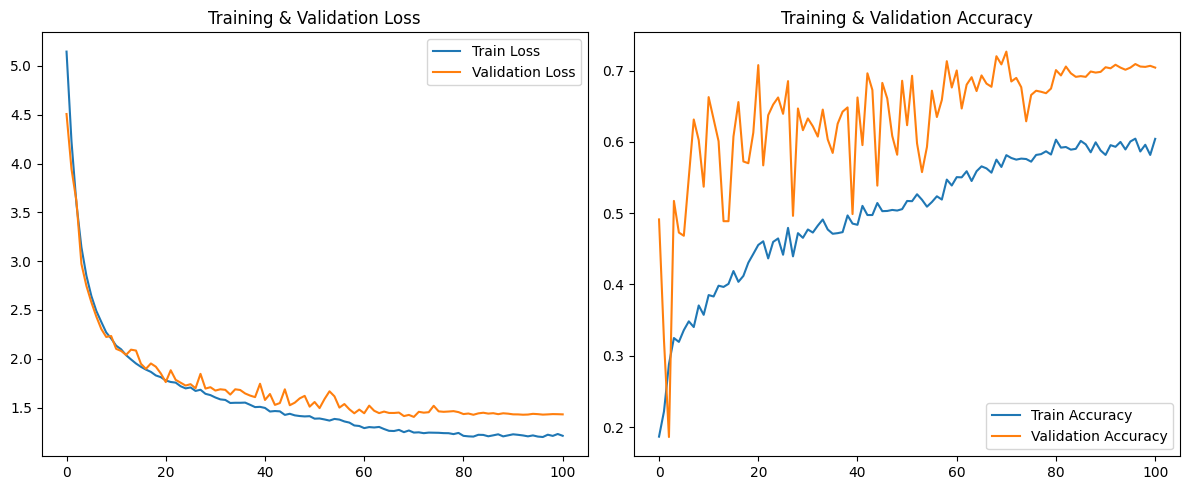

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

110/110 [==============================] - 94s 854ms/step


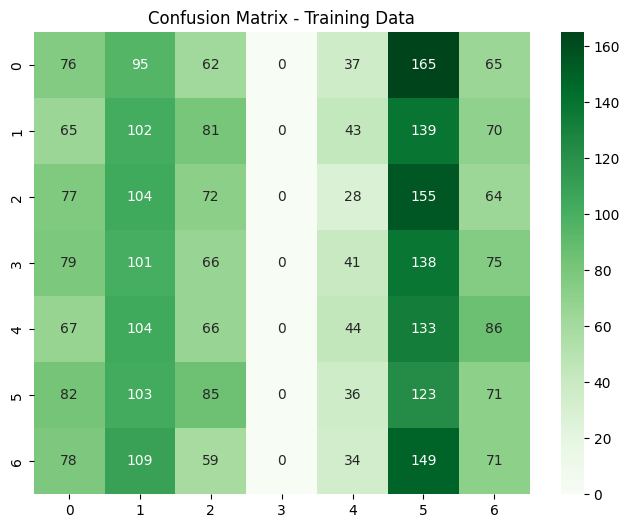

63/63 [==============================] - 14s 219ms/step


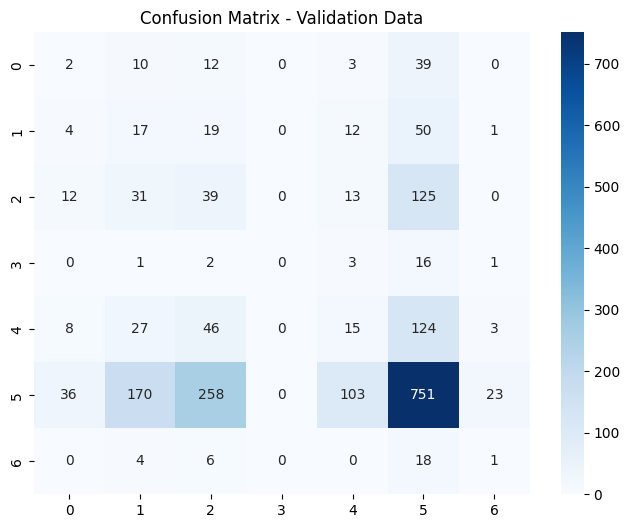

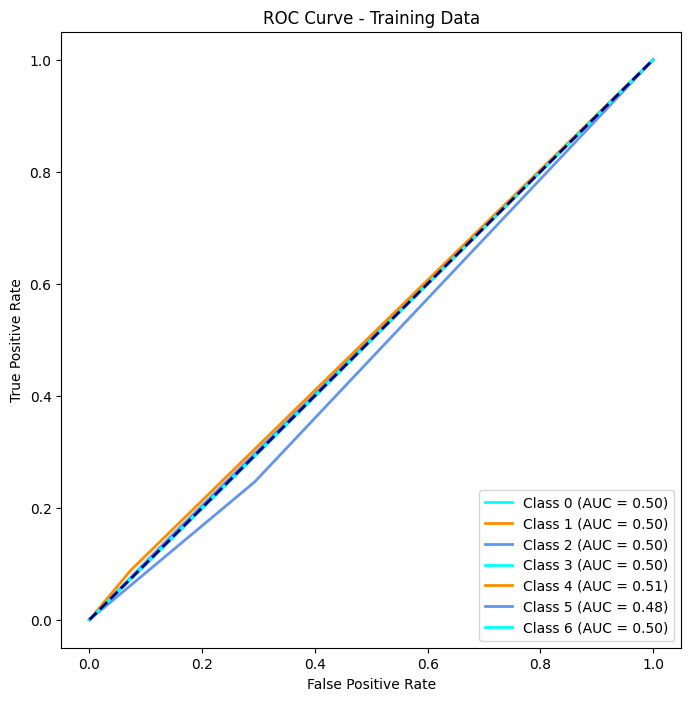

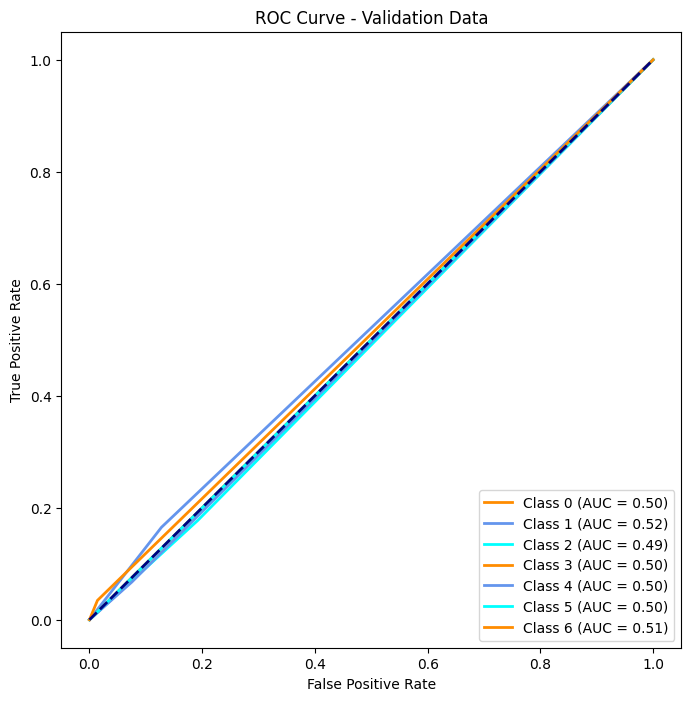

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
